In [1]:
#più canali
#valutare se settare i margini dei firing rates tra 0.16-2Hz come nel paper
#derivata seconda su waveform papers
# un file con bl e stimulato (clustering su tutto e divisione in due classi in base a indice)

In [2]:
from NewLibraryENG import *
from tqdm.notebook import tqdm
import sklearn.preprocessing as ps
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from random import randint
from fastdtw import fastdtw
import copy
import pymc as pm
#name_data = '2018-11-27T10-29-42POP 2 BL .h5'
#name_data = '2018-11-27T12-03-02POP 2 stimulation.h5'
name_data='2018-11-27T10-56-39MiP5 KA stimulation.h5'
#name_data='2018-11-27T11-24-28MiP3 stimulation.h5'
#name_data='2018-11-27T10-40-53POP 3 BL .h5'
#name_data='2019-01-23T11-05-52MIP3 health cortical .h5'
#name_data='2019-01-23T15-49-43MEA2 healthy cortical .h5'
#name_data='2019-01-23T16-22-47Pop3 healthy cortical .h5'
#name_data='2019-01-23T16-06-32Pop1 healthy cortical .h5'

complete_string='/Users/Gaia_1/Desktop/h5files/'+name_data

In [3]:
data = h5py.File(complete_string,'r')

data_readings = data['Data']['Recording_0']['AnalogStream']['Stream_0']['ChannelData'][()]
info = data['Data']['Recording_0']['AnalogStream']['Stream_0']['InfoChannel'][()]
info_table = pd.DataFrame(info, columns = list(info.dtype.fields.keys()))
labels = info_table['Label']
readings = pd.DataFrame(data = data_readings.transpose(), columns = labels)
fs = 10000 #Sampling Frequency
print(readings.shape)

(5875000, 60)


In [4]:
inizio=0
#len_data=810000 #192 secondi
len_data=len(readings)
prova=readings.iloc[inizio:len_data, 10:27]
prova=prova.drop([b'Ref'],axis=1)
ref=readings[b'Ref']
ref=ref[inizio:len_data]

print(prova.shape,ref.shape)

(5875000, 16) (5875000,)


In [5]:
prova_rows = range(prova.shape[0])
filt_prova = pd.DataFrame(data = 0, columns=prova.columns, index=prova_rows, dtype = "float32")
lowcut = 300
highcut = 3000
fs=10000
order=8
b,a=butter_bandpass(lowcut,highcut,fs,order=order)
filt_ref=filtfilt(b,a,ref)
#ref_df = pd.DataFrame({b'Ref': filt_ref})
for x in tqdm(range(prova.shape[1])):
    filt_prova.values[:,x] = scipy.signal.filtfilt(b, a, prova.values[:,x])
for electrode in prova.columns:
    filt_prova[electrode] = filt_prova[electrode] - filt_ref
#filt_prova = pd.concat([filt_prova, ref_df], axis=1)
prova=filt_prova
prova.shape

  0%|          | 0/16 [00:00<?, ?it/s]

(5875000, 16)

# Spike detection

In [6]:
pos_ind=[]
neg_ind=[]
for electrode in tqdm(prova.columns):
    channel=prova[electrode]
    pos, neg=find_all_spikes(channel)
    pos_ind.append(pos)
    neg_ind.append(neg)

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5865000 [00:00<?, ?it/s]

positive spikes 10934 negative spikes 19168 detected spikes: 30102 firing rate:  51.23744680851064


  0%|          | 0/5865000 [00:00<?, ?it/s]

positive spikes 10982 negative spikes 19251 detected spikes: 30233 firing rate:  51.46042553191489


  0%|          | 0/5865000 [00:00<?, ?it/s]

positive spikes 10684 negative spikes 19223 detected spikes: 29907 firing rate:  50.905531914893615


  0%|          | 0/5865000 [00:00<?, ?it/s]

positive spikes 10608 negative spikes 18538 detected spikes: 29146 firing rate:  49.61021276595745


  0%|          | 0/5865000 [00:00<?, ?it/s]

positive spikes 21911 negative spikes 14894 detected spikes: 36805 firing rate:  62.646808510638294


  0%|          | 0/5865000 [00:00<?, ?it/s]

positive spikes 10885 negative spikes 18647 detected spikes: 29532 firing rate:  50.26723404255319


  0%|          | 0/5865000 [00:00<?, ?it/s]

positive spikes 10699 negative spikes 19259 detected spikes: 29958 firing rate:  50.992340425531914


  0%|          | 0/5865000 [00:00<?, ?it/s]

positive spikes 12180 negative spikes 24837 detected spikes: 37017 firing rate:  63.007659574468086


  0%|          | 0/5865000 [00:00<?, ?it/s]

positive spikes 10685 negative spikes 18875 detected spikes: 29560 firing rate:  50.314893617021276


  0%|          | 0/5865000 [00:00<?, ?it/s]

positive spikes 10444 negative spikes 18384 detected spikes: 28828 firing rate:  49.068936170212766


  0%|          | 0/5865000 [00:00<?, ?it/s]

positive spikes 27791 negative spikes 17822 detected spikes: 45613 firing rate:  77.63914893617022


  0%|          | 0/5865000 [00:00<?, ?it/s]

positive spikes 26902 negative spikes 18481 detected spikes: 45383 firing rate:  77.24765957446809


  0%|          | 0/5865000 [00:00<?, ?it/s]

positive spikes 12542 negative spikes 18382 detected spikes: 30924 firing rate:  52.636595744680854


  0%|          | 0/5865000 [00:00<?, ?it/s]

positive spikes 18307 negative spikes 19320 detected spikes: 37627 firing rate:  64.04595744680852


  0%|          | 0/5865000 [00:00<?, ?it/s]

positive spikes 20394 negative spikes 27655 detected spikes: 48049 firing rate:  81.78553191489361


  0%|          | 0/5865000 [00:00<?, ?it/s]

positive spikes 20601 negative spikes 27978 detected spikes: 48579 firing rate:  82.68765957446809


BL: window 3000 (threshold 4 MAD) firing 18    
BL: window 300 (thresh 3), firing 89    
KA: window 3000 (thresh 3), firing 94    
KA: window 3000 (thresh 4), firing 29    
KA: window 300, (thresh 4) firing 39   
KA: window 300, (thresh 3) firing 108   

plt.figure(figsize=(30, 15))
plt.plot(prova, label='Signal Data')
plt.scatter(pos, [prova[i] for i in pos], c='red', marker='o', label='Local Maxima')
plt.scatter(neg, [prova[i] for i in neg], c='green', marker='o', label='Local Minima')
plt.xlabel('Sample Index')
plt.ylabel('Signal Value')
plt.legend()
plt.grid(True)
plt.title('Signal Data with Detected Spikes')
#plt.axis([0,3000,-5,5])
#plt.savefig('spikes1.jpg')
plt.show()

minima,maxima=RMM(prova)
print(len(maxima))
#segnale BASELINE: firing rate=70 (spikes 26148)
#segnale Stimulation: firing rate=69 (spikes 32980)
#segnale KA stimulation: firing rate=81 (spikes 47860)

minima,maxima=find_spikes(prova)
len(maxima)
#segnale BASELINE: firing rate=27 (spikes 10276)
#segnale Stimulation: firing rate=27 (spikes 13198)
#segnale KA stimulation: firing rate=32 (spikes 19178)

minima,maxima=find_spikes_with_memory(prova)
len(maxima)
#segnale BASELINE: firing rate=25 (spikes 9270)
#segnale Stimulation: firing rate=22 (spikes 10579)
#segnale KA stimulation: firing rate=8 (spikes 5054)

plt.figure(figsize=(30, 15))
plt.plot(prova, label='Signal Data')
plt.scatter(minima, [prova[i] for i in minima], c='red', marker='o', label='Local Minima')
plt.scatter(maxima, [prova[i] for i in maxima], c='green', marker='x', label='Local maxima')
plt.xlabel('Sample Index')
plt.ylabel('Signal Value')
plt.legend()
plt.grid(True)
plt.title('Signal Data with Detected Spikes')
#plt.axis([0,30000,-5,5])
#plt.savefig('spikes2.jpg')
plt.show()

# Cutouts

In [9]:
pos_cut=[]
neg_cut=[]
n_pos=[]
n_neg=[]

for i,electrode in enumerate(tqdm(prova.columns)):
    pos=pos_ind[i]
    neg=neg_ind[i]
    channel=prova[electrode]
    pos_cut1,n_pos1, neg_cut1,n_neg1 = cut(pos,neg,channel)
    pos_cut.append(pos_cut1)
    neg_cut.append(neg_cut1)
    n_pos.append(n_pos1)
    n_neg.append(n_neg1)
#savedp = copy.deepcopy(pos_cut)
#savedn = copy.deepcopy(neg_cut)

  0%|          | 0/16 [00:00<?, ?it/s]

In [10]:
for i in (tqdm(range(len(pos_cut)))):
    pos_cut[i]=mask_cuts(pos_cut[i])
    neg_cut[i]= mask_cuts(neg_cut[i])

  0%|          | 0/16 [00:00<?, ?it/s]

x=randint(1,len(pos_cut)-1)
y=randint(1,len(pos_cut[x])-1)

plt.plot(savedp[x][y])
plt.plot(pos_cut[x][y])
plt.show()
#plt.plot(savedn[x])
#plt.plot(neg_cut[x])
#plt.show()

import pandas as pd
pca = PCA()
pca.fit(pos_cut)
explained_variances = pca.explained_variance_ratio_
explained_variance_df = pd.DataFrame(data={'Explained Variance': explained_variances},
                                     index=range(1, len(explained_variances) + 1))
explained_variance_df.transpose()

cumulative_explained_variance = np.cumsum(explained_variances)
cumulative_explained_variance_df = pd.DataFrame(data={'Cumulative Explained Variance': cumulative_explained_variance},
                                                index=range(1, len(cumulative_explained_variance) + 1))
cumulative_explained_variance_df.transpose()


# Clustering

final_data_pos=[]
for channel in (tqdm(range(len(pos_cut)))):
    channel_clusters= hdbscan_clustering(pos_cut[channel],n_pos[channel],prova.iloc[:,channel])
    final_data_pos.append(channel_clusters)
    

BL (window 3000, thresh 4) (less function) fuzzy (1.8, 4, 3.99)   
BL (window 300) (less function) fuzzy (19, 18, 9)   
BL (window 300) (less function) dbscan (30, 9)   
BL (window 300) (bit less function std) fuzzy (8.9, 18.2, 17.8)   
BL (window 300) (more cut function) fuzzy (8.9, 17.7, 18.3)   
BL (window 300) (more cut function) dbscan (29, 6)   
BL (less cut function) fuzzy: (15, 8 ,15)   

KA (window 300, thresh 4) (less function) fuzzy (3.8, 4, 1.9)   
KA (window 3000, thresh 4) (less function) fuzzy (2.6, 1.2, 2.8)   
KA stimualtion 3 clusters fuzzy: (13, 6, 12)   
KA stim (window 300) (new cut function) (1.17,2.55,2.37)   

firing rate between 0.16 and 2 Hz
fr=len(cluster)*10000/len(alldata)=0.16-:2
len(cluster)=len(spike_list)/n_clusters
len(spike_list)*10.000/n_clusters*len(alldata)=0.16-2
n_min=10.000*len(spike_list)/2*len(alldata)
n_max=10.000*len(spike_list)/0.16*len(alldata)


final_data_neg=[]
for channel in (tqdm(range(len(neg_cut)))):
    channel_clusters= hdbscan_clustering(neg_cut[channel],n_neg[channel],data)
    final_data_neg.append(channel_clusters)

In [11]:
def bounded_clus_try(cut,clustering,spike_list,data):
    from sklearn.cluster import KMeans
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    from sklearn import metrics
    from sklearn.metrics import silhouette_score
    from scipy.stats import kurtosis
    import skfuzzy as fuzz
    import numpy as np
    import math
    spike_list=np.array(spike_list)
    len_data=len(data)
    n_min=int((10000*len(spike_list))/(2*len_data))
    n_tries=int(((10000*len(spike_list))/(0.16*len_data)+1))
    print('cluster range: ',n_min,n_tries)
    scale = StandardScaler()
    estratti_norm = scale.fit_transform(cut)
    print('Total spikes: ', estratti_norm.shape[0])
    n_comp=10
    pca = PCA(n_components=n_comp)
    transformed = pca.fit_transform(estratti_norm)

    info=[]
    list_score=[]
    DB_score=[]
    best_score=[]
    #CH_score=[]
    if clustering=='kmeans':
        for n in tqdm(range (n_min,n_tries)):
            model = KMeans(n_clusters=n, n_init='auto', copy_x=True, algorithm='lloyd')
            labels = model.fit_predict(transformed)
            if (n != 1):
                silhouette_avg = silhouette_score(transformed, labels)
                #CH=metrics.calinski_harabasz_score(transformed, labels)
                DB=metrics.davies_bouldin_score(transformed, labels)
                #print("For", n,"clusters, the silhouette score is:", format(silhouette_avg, ".3f"),'DB score',format(DB, ".3f"))
                list_score.append(silhouette_avg)
                DB_score.append(DB/10)
                #best_score.append(silhouette_avg-(DB/10))
                #CH_score.append(CH/3000)
                #best_score.append(silhouette_avg)
                del(model)
                del(labels)
        #top_clusters = (list_score.index(max(list_score)))+n_min
        #top_DB=(DB_score.index(max(DB_score)))+n_min
        top_clusters=(DB_score.index(min(DB_score)))+n_min
        print('top cluster: ',(DB_score.index(min(DB_score))),'+',n_min,'=',top_clusters)
        #n_clusters=top_clusters
        plt_value=min(DB_score)
        plt_index=DB_score.index(min(DB_score))
        '''
        if top_clusters==top_DB:
            num_clusters=top_clusters
        else:
            num_clusters=(DB_score.index(max(DB_score)))+n_min
        '''    
        plt.figure()
        #x=np.arange(n_min,n_tries)
        plt.plot(list_score)
        plt.plot(DB_score)
        #plt.plot(CH_score)
        plt.title('Silhouette score')
        plt.xlabel('Number of clusters')
        #plt.xlabel('x')
        #plt.ylim(0,2)
        plt.scatter((list_score.index(max(list_score))), max(list_score), c='red', marker='o', label='Maximum s score')
        plt.scatter(plt_index, plt_value, c='green', marker='o', label='Minimum DB score')
        #plt.scatter((CH_score.index(max(CH_score))), max(CH_score), c='blue', marker='o', label='Maximum CH score')
        #plt.scatter((best_score.index(min(best_score))), min(best_score), c='blue', marker='x', label='Best sil - DB score')
        plt.show()

        #top_clusters=num_clusters
        print("\n\n\033[1;31;47mBest cluster in the range", n_min, "to ", n_tries-1, ": ",plt_index,top_clusters,", with a silhouette score of: ",list_score[top_clusters-n_min],'DB score: ',DB_score[top_clusters-n_min],plt_value, "\u001b[0m  \n\n")

        model = KMeans(n_clusters=top_clusters, n_init='auto', copy_x=True, algorithm='lloyd')
        labels = model.fit_predict(transformed)
    elif clustering == 'fuzzy':
        for n in range (n_min,n_tries):
            cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(transformed.T, n, 2, error=0.005, maxiter=3000, init=None)
            labels = np.argmax(u, axis=0)
            if (n !=1):
                silhouette_avg = silhouette_score(transformed, labels)
                #CH=metrics.calinski_harabasz_score(transformed, labels)
                DB=metrics.davies_bouldin_score(transformed, labels)
                print("For", n,"clusters, the silhouette score is:", format(silhouette_avg, ".3f"))#, 'CH score',format(CH, ".3f"),'DB score',format(DB, ".3f"))
                list_score.append(silhouette_avg)
                DB_score.append(DB)
                #best_score.append(2*silhouette_avg-DB)
                best_score.append(silhouette_avg)
                del(u)
                del(labels)

        top_clusters = (best_score.index(max(best_score)))+n_min
        plt.figure()
        #x=np.arange(n_min,n_tries)
        plt.plot(list_score)
        plt.plot(DB_score)
        #plt.plot(CH_score)
        plt.title('Silhouette score')
        plt.xlabel('Number of clusters')
        #plt.xlabel('x')
        #plt.ylim(0,2)
        plt.scatter((list_score.index(max(list_score))), max(list_score), c='red', marker='o', label='Maximum s score')
        plt.scatter(plt_index, plt_value, c='green', marker='o', label='Minimum DB score')
        #plt.scatter((CH_score.index(max(CH_score))), max(CH_score), c='blue', marker='o', label='Maximum CH score')
        #plt.scatter((best_score.index(min(best_score))), min(best_score), c='blue', marker='x', label='Best sil - DB score')
        plt.show()
        #creare vettore con (silhouette - DB) e selezionare massimo
        print("\n\n\033[1;31;47mBest cluster in the range",n_min," to ", n_tries-1, ":" ,top_clusters,", with a silhouette score of: ",best_score[top_clusters-n_min])#,'DB:',DB_score[top_clusters-n_min], "\u001b[0m  \n\n")
        cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(transformed.T, top_clusters, 2, error=0.005, maxiter=3000, init=None)
        labels = np.argmax(u, axis=0)
        

    final_data=[]
    temporary_data=[]
    unique_labels = np.unique(labels)
    firings=np.zeros(len(unique_labels))
    fig = plt.figure(figsize=(10, 12))

    # Iterate over unique cluster labels
    for i, cluster_label in enumerate(unique_labels):
        # Extract data points for the current cluster
        cluster_data = cut[labels == cluster_label]
        firings[i]=len(cluster_data)*10000/len_data

        # Plot the individual cluster data
        if len(unique_labels)<=2:
            size1=len(unique_labels)
            size2=1
        elif len(unique_labels)<=5:
            size1 = math.ceil(len(unique_labels)/2)
            size2=size1
        elif len(unique_labels)<=9:
            size1 = 3
            size2=math.ceil(len(unique_labels)/size1)
        else:
            size1=10
            size2=math.ceil(len(unique_labels)/size1)
        plt.subplot(size1,size2, i + 1)
        plt.plot(cluster_data.transpose(), alpha=0.5)  # Use alpha for transparency
        #print(cluster_data)
        plt.title(f'Cluster {cluster_label} \n numerosity: {len(cluster_data)}')
        plt.xlabel('Time [ms]')
        plt.ylabel('Signal Amplitude')

        # Plot the average waveform
        mean_wave = np.mean(cluster_data, axis=0)
        info.append(f'mean clus{cluster_label}')
        info.append(mean_wave)
        std_wave = np.std(cluster_data, axis=0)
        plt.errorbar(range(mean_wave.shape[0]), mean_wave, yerr=std_wave, color='black', linewidth=2, label='Avg. Waveform')
        plt.legend(loc='lower right')
    plt.tight_layout()

    mean_firing=np.mean(firings)
    std_firing=np.std(firings)
    firing_threshold=mean_firing-std_firing
    print('firing rate threshold: ',firing_threshold)
    info.append('firing threshold')
    info.append(firing_threshold)
    info.append('mean firing')
    info.append(mean_firing)
    plt.subplots_adjust(hspace=0.5)
    plt.show()

    for i in range(0,len(unique_labels)):
        ul=spike_list[labels==i]
        temporary_data.append(ul)
        fr=len(temporary_data[i])*10000/len_data
        if i != -1 and fr>firing_threshold:
            final_data.append(ul)
        plt.subplot(size1, size2, i + 1)
        plt.hist(np.diff(ul), bins=100, density=True, alpha=0.5, color='blue', edgecolor='black')
        plt.title(f'ISI: Cluster {i}, \n firing rate: {format(len(temporary_data[i])*10000/len_data, ".3f")}')
    plt.subplots_adjust(hspace=2.5)
    plt.show()
    print(f'{top_clusters} clusters, firing rates: {firings}')
    del(unique_labels)
    return final_data


In [12]:
# togliere dal best score il DB score e usare solo il silhouette score ma su 15 prove
# fare scrematura una volta formati i clusters, togliendo gli spike con distanza DTW sopra soglia
# provare anche DTW tra medie di cluster

  0%|          | 0/16 [00:00<?, ?it/s]

cluster range:  9 117
Total spikes:  10934


  0%|          | 0/108 [00:00<?, ?it/s]

top cluster:  4 + 9 = 13


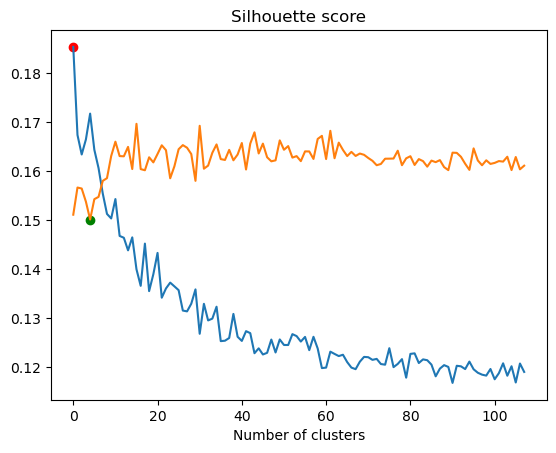



Best cluster in the range 9 to  116 :  4 13 , with a silhouette score of:  0.17175467447630957 DB score:  0.15011157051313687 0.15011157051313687   


firing rate threshold:  0.8420731203557458


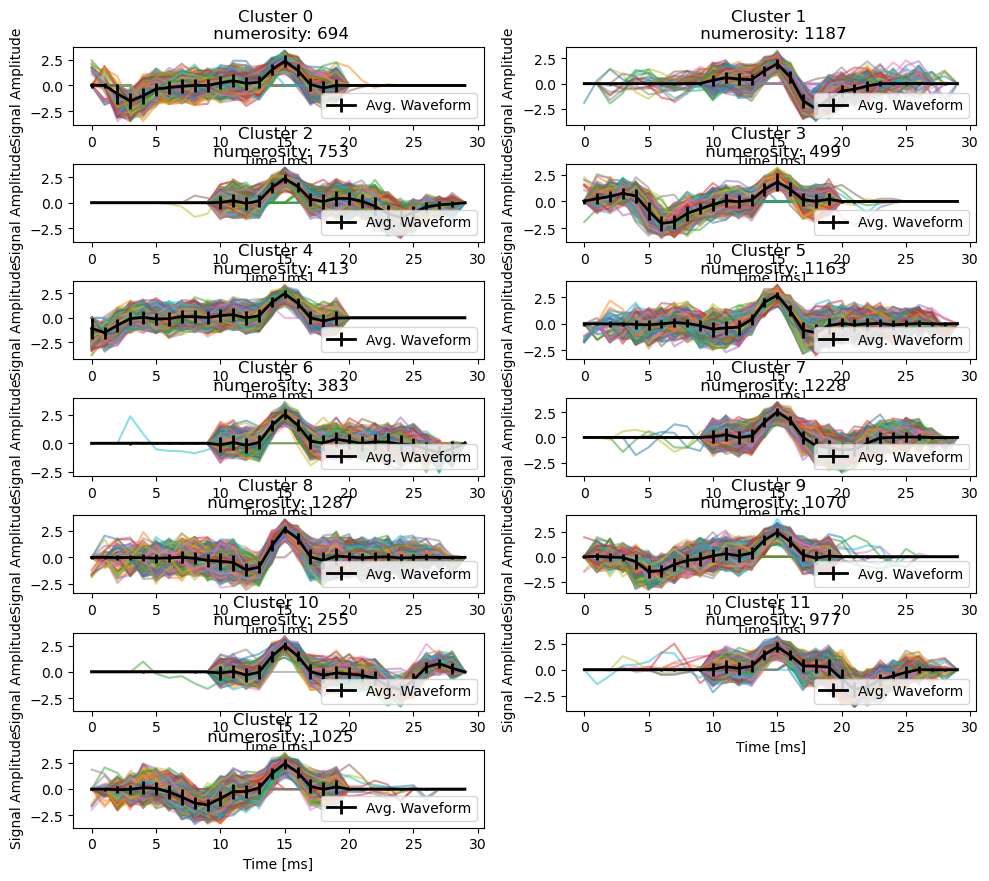

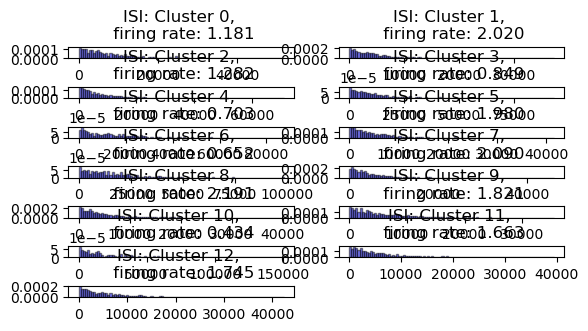

13 clusters, firing rates: [1.1812766  2.02042553 1.28170213 0.8493617  0.70297872 1.97957447
 0.65191489 2.09021277 2.1906383  1.8212766  0.43404255 1.66297872
 1.74468085]
cluster range:  9 117
Total spikes:  10982


  0%|          | 0/108 [00:00<?, ?it/s]

top cluster:  6 + 9 = 15


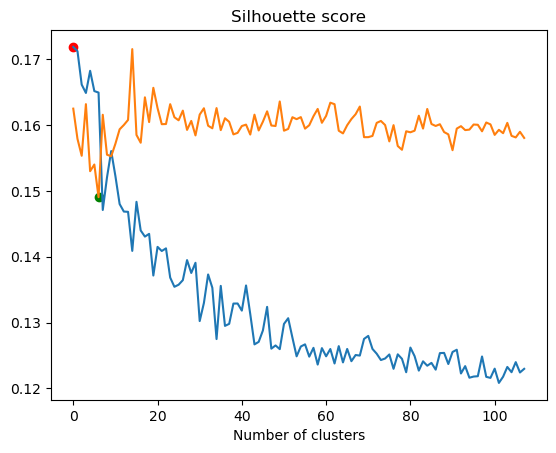



Best cluster in the range 9 to  116 :  6 15 , with a silhouette score of:  0.16496957907645662 DB score:  0.14906001665331306 0.14906001665331306   


firing rate threshold:  0.7610344708688346


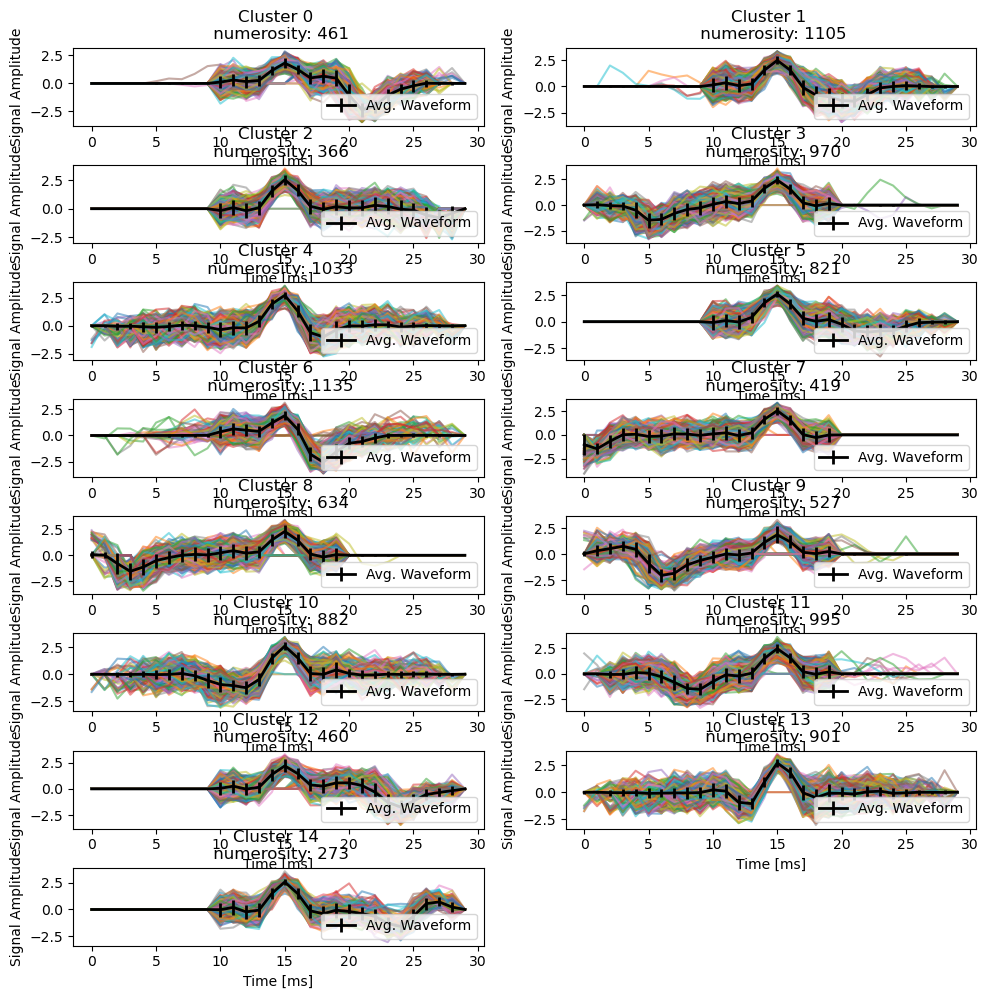

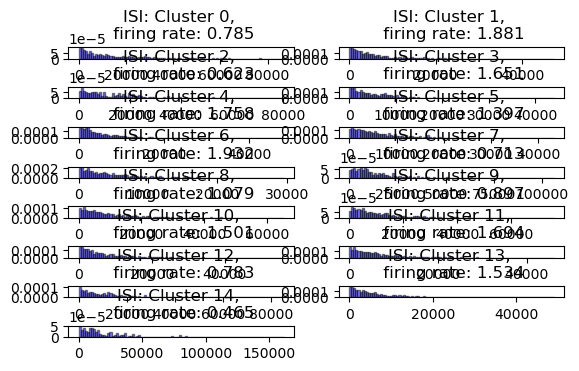

15 clusters, firing rates: [0.78468085 1.88085106 0.62297872 1.65106383 1.75829787 1.39744681
 1.93191489 0.71319149 1.07914894 0.89702128 1.5012766  1.69361702
 0.78297872 1.53361702 0.46468085]
cluster range:  9 114
Total spikes:  10684


  0%|          | 0/105 [00:00<?, ?it/s]

top cluster:  4 + 9 = 13


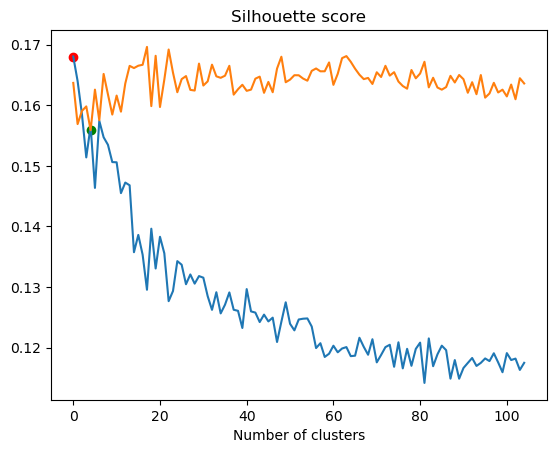



Best cluster in the range 9 to  113 :  4 13 , with a silhouette score of:  0.15658879892597946 DB score:  0.1558885437387688 0.1558885437387688   


firing rate threshold:  0.9321043699138194


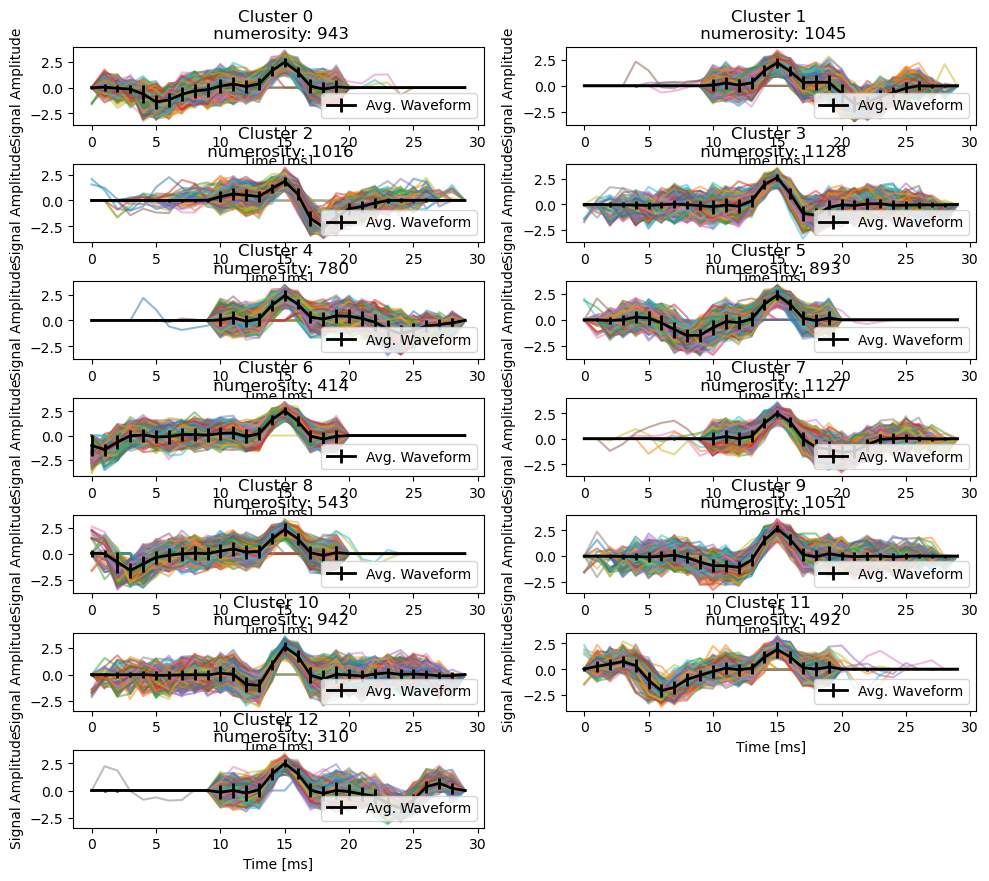

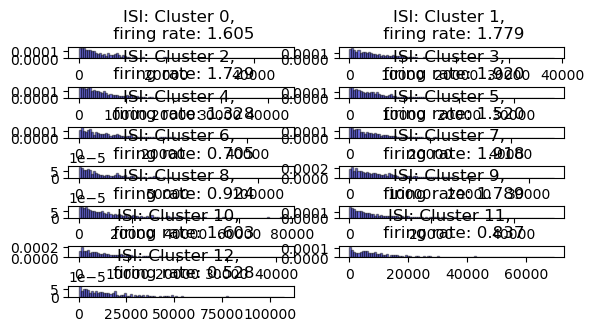

13 clusters, firing rates: [1.60510638 1.7787234  1.7293617  1.92       1.32765957 1.52
 0.70468085 1.91829787 0.92425532 1.78893617 1.60340426 0.83744681
 0.52765957]
cluster range:  9 113
Total spikes:  10607


  0%|          | 0/104 [00:00<?, ?it/s]

top cluster:  4 + 9 = 13


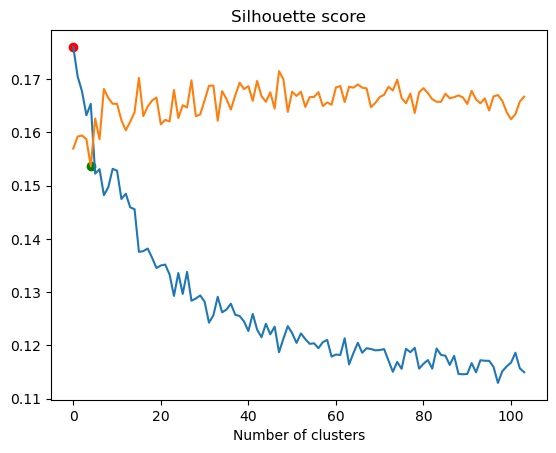



Best cluster in the range 9 to  112 :  4 13 , with a silhouette score of:  0.1653234497605004 DB score:  0.15361013557533326 0.15361013557533326   


firing rate threshold:  0.934144490452854


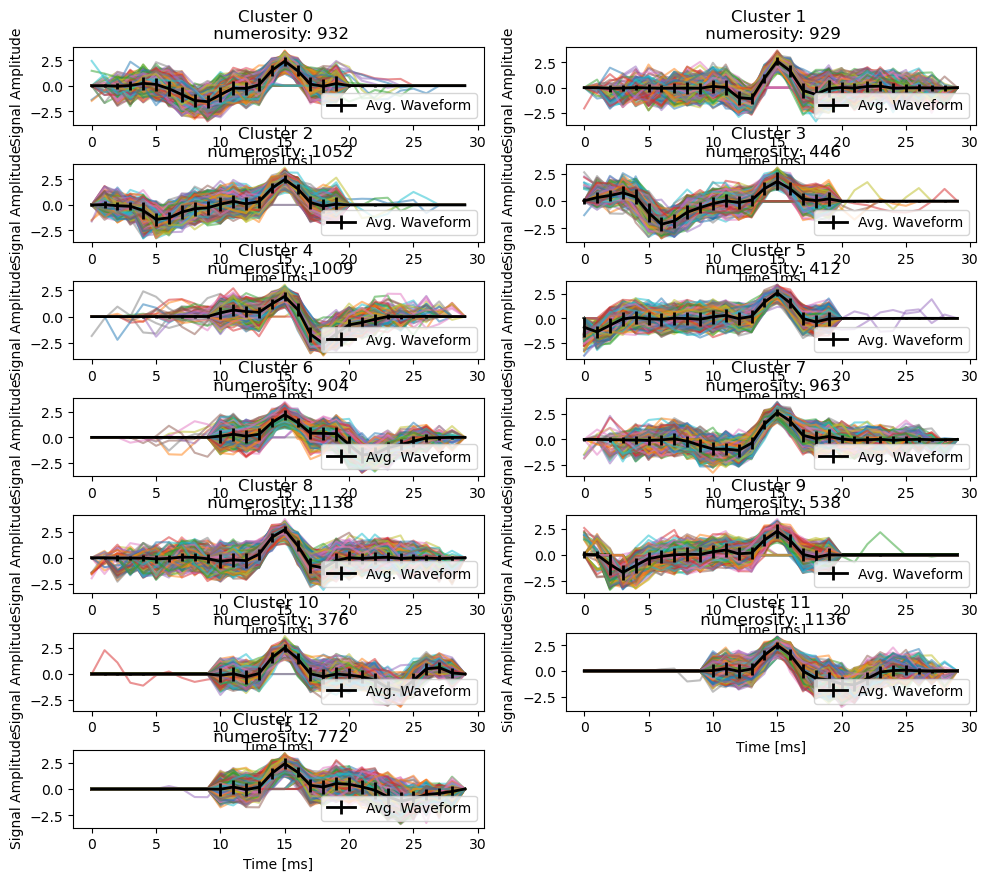

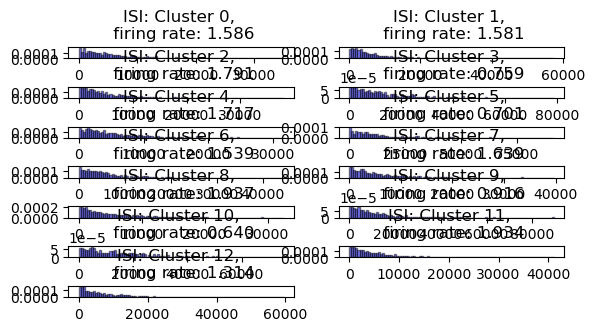

13 clusters, firing rates: [1.58638298 1.5812766  1.7906383  0.75914894 1.71744681 0.7012766
 1.5387234  1.63914894 1.93702128 0.91574468 0.64       1.93361702
 1.31404255]
cluster range:  18 234
Total spikes:  21911


  0%|          | 0/216 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [14]:
final_data_pos=[]
for channel in (tqdm(range(len(pos_cut)))):
    channel_clusters=bounded_clus_try(pos_cut[channel],'kmeans',n_pos[channel],prova.iloc[:,channel])
    final_data_pos.append(channel_clusters)

In [ ]:
final_data_neg=[]
print(name_data)
for channel in (tqdm(range(len(neg_cut)))):
    channel_clusters=bounded_clus_try(neg_cut[channel],'kmeans',n_neg[channel],prova.iloc[:,channel])
    final_data_neg.append(channel_clusters)

BL (less cut function) (window 3000, thresh4) fuzzy: (3.5, 3.5, 1.6) silhouette: 0.231    
BL (less cut function) (window 300) fuzzy: (17, 15, 6) silhouette: 0.215    
BL (more cut function) (window 300) fuzzy: (15, 16, 7) silhouette: 0.218    
BL (less cut function) fuzzy: (13, 13, 6) silhouette: 0.226    

KA (less cut function) (window 300, thresh4) fuzzy: (1.9, 1.12, 1.9) silhouette: 0.229   
KA (less cut function) (window 3000, thresh4) fuzzy: (1.4, 0.89, 1.4) silhouette: 0.223    
KA stimulation 3 clusters fuzzy: (3.9, 3.7, 2) silhouette: 0.214    
KA stimulation (more cut function) (window 3000) fuzzy: (2, 3.9, 3.7) silhouette: 0.214    
KA stimulation (more cut function) (window 300) fuzzy (4.5, 4.4, 2.2) silhouette: 0.204    
KA stimulation (more cut function) (window 300) dbscan (10.8,10.8)    

# Save

In [17]:
len(final_data_pos[0][0])

694

In [19]:
neurons=[]
min_len=len(final_data_pos[0][0])
for electrode in final_data_pos:
    for neuron in electrode:
        #if len(neuron)>1000:
        min_len=min(min_len,len(neuron))
        neurons.append(neuron)
        print(len(neuron))
print('positive neurons:',len(neurons))


694
1187
753
499
1163
1228
1287
1070
977
1025
461
1105
970
1033
821
1135
634
527
882
995
460
901
943
1045
1016
1128
780
893
1127
1051
942
932
929
1052
1009
904
963
1138
1136
772
positive neurons: 40


In [ ]:
for electrode in final_data_neg:
    for neuron in electrode:
        #if len(neuron)>1000:
        neurons.append(neuron)
        min_len=min(min_len,len(neuron))
        print(len(neuron))
print('negative neurons: ',len(neurons))

In [20]:
len(neurons[21])

901

In [106]:
adj_neur=[]
for neuron in neurons:
    neu=neuron#[0:min_len]
    adj_neur.append(neu)
print(min_len,len(adj_neur))

460 40


neurons = []
lens=[]
for electrode in final_data_pos:
    for neuron in electrode:
        if len(neuron)>1000:
            lens.append(len(neuron))
for neuron in final_data_neg:
    for neuron in electrode:
        if len(neuron)>1000:
            lens.append(len(neuron))

avg_len=int(np.mean(lens))
for electrode in final_data_pos:
    for neuron in electrode:
        if len(neuron)>1000:
            print(len(neuron))
            diff = avg_len-len(neuron)
            if diff<0:
                neurons.append(neuron[0:avg_len])
            else:
                neurons.append(np.concatenate((neuron,np.zeros([diff]))))
print(len(neurons),avg_len)

for neuron in final_data_neg:
    for neuron in electrode:
        if len(neuron)>1000:
            print(len(neuron))
            diff = avg_len-len(neuron)
            if diff<0:
                neurons.append(neuron[0:avg_len])
            else:
                neurons.append(np.concatenate((neuron,np.zeros([diff]))))
print(len(neurons),avg_len)

adj_neur=[]
counter = 0
max_len=0

for neu in neurons:
    print('counter: ',counter,neu.shape[0])
    if neu.shape[0]>max_len:
        max_len=neu.shape[0]
    counter+=1
for neuron in neurons:
    if neuron.shape[0]<=max_len:
        diff = max_len-neuron.shape[0]
        adj_neur.append(np.concatenate((neuron,np.zeros([diff]))))
print(max_len)

In [26]:
save_data = 'After'+name_data+'.txt'
print(name_data)

2018-11-27T10-56-39MiP5 KA stimulation.h5


In [27]:
np.savetxt("/Users/Gaia_1/Desktop/tesi/Data after SS/%s.txt" % save_data,adj_neur, delimiter=', ', fmt='%12.8f')

## Point Process

In [121]:
x=randint(0,len(neurons))
#x=21
print('neur: ',x)
#if len(neurons[x])>1000:
print('length: ',len(adj_neur[x]))
data_healthy=adj_neur[x]
ISI_healthy = np.diff(data_healthy)/10000
#else:
    #print('try again')

neur:  1
length:  1187


(array([60., 49., 44., 38., 27., 19., 34., 26., 12., 18., 18., 15., 11.,
         9., 10.,  7.,  9.,  9.,  4.,  7.,  0.,  7.,  4.,  2.,  4.,  3.,
         2.,  0.,  1.,  1.,  0.,  1.,  0.,  2.,  1.,  2.,  0.,  0.,  0.,
         2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([1.800000e-03, 8.494800e-02, 1.680960e-01, 2.512440e-01,
        3.343920e-01, 4.175400e-01, 5.006880e-01, 5.838360e-01,
        6.669840e-01, 7.501320e-01, 8.332800e-01, 9.164280e-01,
        9.995760e-01, 1.082724e+00, 1.165872e+00, 1.249020e+00,
        1.332168e+00, 1.415316e+00, 1.498464e+00, 1.581612e+00,
        1.664760e+00, 1.747908e+00, 1.831056e+00, 1.914204e+00,
        1.997352e+00, 2.080500e+00, 2.163648e+00, 2.246796e+00,
        2.329944e+00, 2.413092e+00, 2.496240e+00, 2.579388e+00,
        2.662536e+00, 2.745684e+00, 2.828832e+00, 2.911980e+00,
        2.995128e+00, 3.078276e+00, 3.161424e+00, 3.244572e+00,
        3.327720e+00, 3.410868e+00, 3.494016e+00, 3.577164e+00,
        3.66

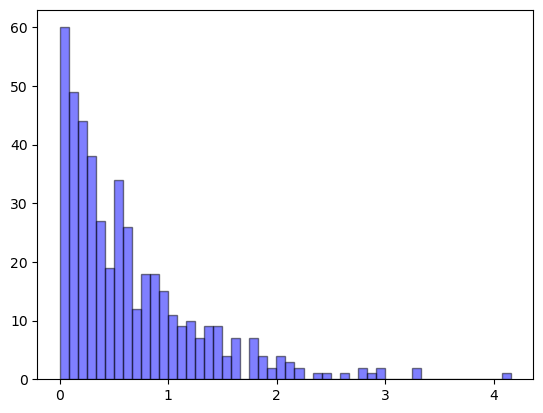

In [105]:
locs_diff=np.diff(data_healthy)
#plt.axis([-3,500,0,0.05])
plt.hist(ISI_healthy, bins=50, density=False, alpha=0.5, color='blue', edgecolor='black')

In [122]:
map_estimate,ppc_trace = Bayesian_mixture_model(ISI_healthy)

Sequential sampling (1 chains in 1 job)
NUTS: [mu1, lam1, mu2, sigma2, mu3, sigma3, w]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 36 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sampling: [like]


(array([60., 49., 44., 38., 27., 19., 34., 26., 12., 18., 18., 15., 11.,
         9., 10.,  7.,  9.,  9.,  4.,  7.,  0.,  7.,  4.,  2.,  4.,  3.,
         2.,  0.,  1.,  1.,  0.,  1.,  0.,  2.,  1.,  2.,  0.,  0.,  0.,
         2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([1.800000e+01, 8.494800e+02, 1.680960e+03, 2.512440e+03,
        3.343920e+03, 4.175400e+03, 5.006880e+03, 5.838360e+03,
        6.669840e+03, 7.501320e+03, 8.332800e+03, 9.164280e+03,
        9.995760e+03, 1.082724e+04, 1.165872e+04, 1.249020e+04,
        1.332168e+04, 1.415316e+04, 1.498464e+04, 1.581612e+04,
        1.664760e+04, 1.747908e+04, 1.831056e+04, 1.914204e+04,
        1.997352e+04, 2.080500e+04, 2.163648e+04, 2.246796e+04,
        2.329944e+04, 2.413092e+04, 2.496240e+04, 2.579388e+04,
        2.662536e+04, 2.745684e+04, 2.828832e+04, 2.911980e+04,
        2.995128e+04, 3.078276e+04, 3.161424e+04, 3.244572e+04,
        3.327720e+04, 3.410868e+04, 3.494016e+04, 3.577164e+04,
        3.66

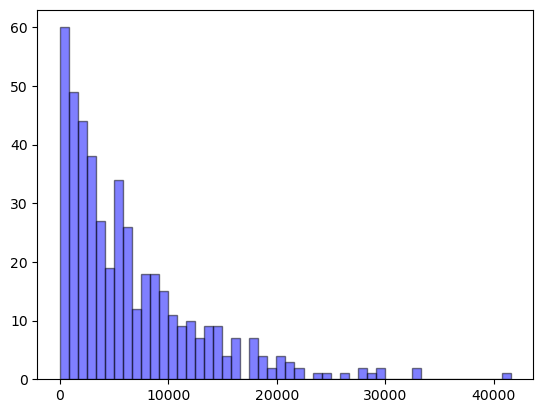

In [94]:
plt.hist(ISI_healthy, bins=50, density=False, alpha=0.5, color='blue', edgecolor='black')
#plt.plot(hist[0])

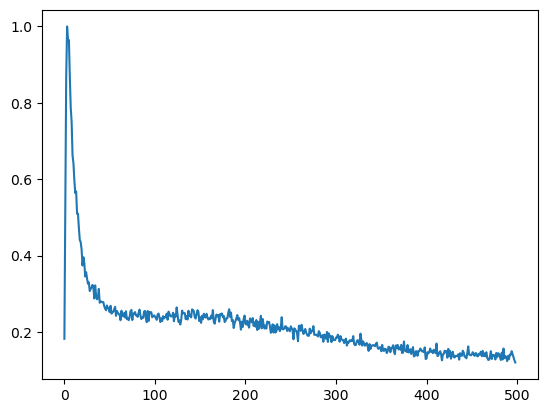

In [73]:
plt.plot(hist[0]/max(hist[0]))

In [63]:
hist[1][:-1]

array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
       0.009, 0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017,
       0.018, 0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026,
       0.027, 0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035,
       0.036, 0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044,
       0.045, 0.046, 0.047, 0.048, 0.049, 0.05 , 0.051, 0.052, 0.053,
       0.054, 0.055, 0.056, 0.057, 0.058, 0.059, 0.06 , 0.061, 0.062,
       0.063, 0.064, 0.065, 0.066, 0.067, 0.068, 0.069, 0.07 , 0.071,
       0.072, 0.073, 0.074, 0.075, 0.076, 0.077, 0.078, 0.079, 0.08 ,
       0.081, 0.082, 0.083, 0.084, 0.085, 0.086, 0.087, 0.088, 0.089,
       0.09 , 0.091, 0.092, 0.093, 0.094, 0.095, 0.096, 0.097, 0.098,
       0.099, 0.1  , 0.101, 0.102, 0.103, 0.104, 0.105, 0.106, 0.107,
       0.108, 0.109, 0.11 , 0.111, 0.112, 0.113, 0.114, 0.115, 0.116,
       0.117, 0.118, 0.119, 0.12 , 0.121, 0.122, 0.123, 0.124, 0.125,
       0.126, 0.127,

In [83]:
max(ISI_healthy)

4.1592

In [86]:
ISI_healthy

array([1.2918e+00, 3.1100e-02, 3.1800e-02, 7.2200e-02, 1.2450e+00,
       7.3560e-01, 2.1273e+00, 2.9646e+00, 5.5200e-02, 2.4000e-03,
       2.4411e+00, 5.2910e-01, 2.0702e+00, 1.0877e+00, 1.2207e+00,
       4.1592e+00, 3.3166e+00, 5.8190e-01, 1.4450e-01, 8.2480e-01,
       6.8880e-01, 2.4010e+00, 6.4310e-01, 5.6280e-01, 4.4720e-01,
       9.0270e-01, 5.7000e-01, 1.3360e-01, 8.4750e-01, 9.7340e-01,
       4.7260e-01, 9.6010e-01, 1.8000e-03, 1.0510e-01, 1.1820e-01,
       1.1410e+00, 6.4090e-01, 3.1550e-01, 2.5760e-01, 6.0930e-01,
       1.0050e-01, 1.4780e-01, 1.8320e-01, 4.9280e-01, 1.5750e-01,
       2.5940e-01, 3.2802e+00, 7.1800e-02, 4.4080e-01, 9.3300e-01,
       8.3840e-01, 1.4120e+00, 8.4660e-01, 6.9200e-01, 1.6302e+00,
       1.1185e+00, 2.2390e-01, 2.8120e-01, 1.3922e+00, 3.1190e-01,
       1.3430e-01, 3.3080e-01, 2.3900e-02, 6.6220e-01, 3.2670e-01,
       6.6050e-01, 3.3700e-02, 1.8628e+00, 4.0890e-01, 3.7840e-01,
       1.5893e+00, 1.5100e-02, 9.6730e-01, 2.8690e-01, 1.9490e

In [85]:
max(ISI_healthy/max(ISI_healthy))

1.0

(array([3., 3., 2., 5., 2., 2., 3., 7., 4., 0., 1., 3., 6., 2., 3., 2., 3.,
        5., 0., 4., 2., 1., 0., 2., 3., 3., 3., 1., 2., 2., 3., 2., 3., 3.,
        4., 2., 3., 3., 4., 2., 1., 2., 3., 2., 3., 3., 3., 2., 4., 2., 1.,
        4., 0., 2., 2., 3., 4., 2., 1., 1., 0., 1., 2., 2., 2., 1., 1., 2.,
        2., 1., 1., 2., 2., 1., 4., 1., 2., 5., 2., 4., 1., 1., 0., 0., 3.,
        2., 2., 0., 0., 1., 4., 2., 0., 2., 0., 0., 3., 2., 1., 2., 3., 1.,
        1., 0., 0., 2., 1., 1., 0., 1., 1., 1., 0., 3., 0., 1., 0., 0., 3.,
        1., 1., 0., 3., 0., 2., 0., 4., 3., 3., 2., 3., 1., 2., 0., 2., 1.,
        1., 2., 0., 3., 1., 2., 1., 0., 0., 3., 4., 4., 2., 0., 0., 0., 0.,
        0., 3., 2., 0., 1., 3., 1., 1., 1., 1., 0., 1., 1., 2., 0., 0., 0.,
        0., 1., 0., 0., 2., 0., 2., 0., 0., 0., 2., 2., 1., 0., 0., 1., 1.,
        1., 0., 1., 0., 1., 0., 0., 2., 0., 0., 0., 5., 1., 0., 1., 2., 2.,
        2., 1., 2., 1., 2., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0.,
        2., 

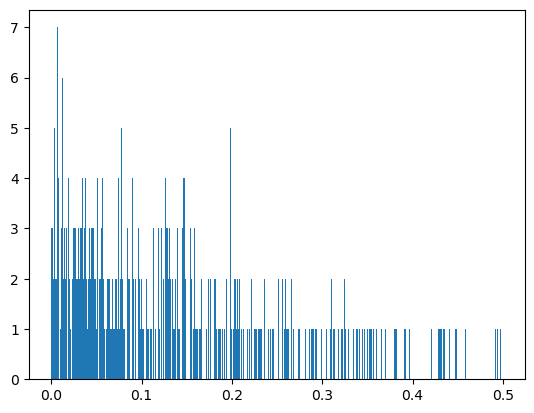

In [84]:
plt.hist(ISI_healthy/max(ISI_healthy),bins)

In [97]:
len(bins)

50

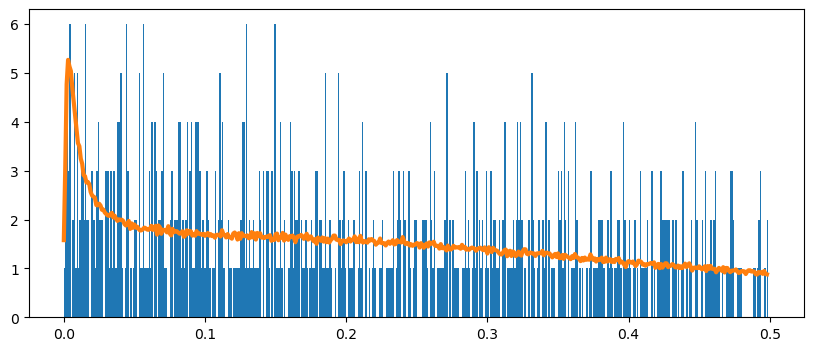

In [123]:
bins = np.arange(0, .5, 1e-3) 
plt.figure (figsize=(10,4))

hist = np.histogram(ppc_trace['posterior_predictive']['like'].values,bins=bins)
#plt.axis([0,0.3,0,160])
a= plt.hist(ISI_healthy,bins)
plt.plot(hist[1][:-1],hist[0]/1000,linewidth=3);

In [ ]:
lista_samples=[]
for i in list(ppc_trace['posterior_predictive']['like'].values):
    lista_samples.extend(i)

In [ ]:
counts, _ = np.histogram(ISI_healthy, bins) 
prob_emp = counts / np.sum(counts)
counts, _ = np.histogram(lista_samples, bins) 
prob_model = counts / np.sum(counts)

Femp = np.cumsum(prob_emp)           
Fmodel = np.cumsum(prob_model)          
plt.figure()
plt.plot(bins[:-1], Femp)                
plt.plot(bins[:-1], Fmodel, 'r')       
#plt.xlim([0, 0.2])                  
plt.xlabel('Time [s]')
plt.ylabel('CDF')
plt.legend(['Empirical','Model'])
plt.show()

In [ ]:
plt.figure()
Nlow = len(ISI_healthy)  
# Plot the confidence bounds
plt.plot([0, 1], [x + 1.36 / np.sqrt(Nlow) for x in [0, 1]], 'r:')
plt.plot([0, 1], [x - 1.36 / np.sqrt(Nlow) for x in [0, 1]], 'r:')
plt.plot(Femp, Fmodel)
plt.axis([0, 1, 0, 1])         
plt.xlabel('Model CDF')
plt.ylabel('Empirical CDF')
plt.show()

# Multiple channel point process

In [ ]:
dataframe = pd.DataFrame()
list_neurons = neurons
counter=0
print('Original number of neurons: ',len(list_neurons))
net=name_data
for neuron in list_neurons:
    neuron=neuron[neuron>0*10000]
    neuron=neuron[neuron<200*10000]
    print('  Neuron with ',neuron.shape[0],'spikes')
    if neuron.shape[0]>1000:

        counter+=1
    else:
        print('    Excluded neuron with n spikes = ',neuron.shape[0])
        continue

    ISI_healthy = np.diff(neuron)/10000


    map_estimate = Bayesian_mixture_model(ISI_healthy)
    if 'Healthy' in net:
        print('target Healthy')
        map_estimate['Target']=0

    elif 'healthy' in net:
        print('target healthy')
        map_estimate['Target']=0

    elif 'health' in net:
        print('target health')
        map_estimate['Target']=0

    else:
        print('target pathological')
        map_estimate['Target']=1

    if 'KA' in net:
        map_estimate['Stimulation']=1

    elif 'stimulation' in net:
        map_estimate['Stimulation']=1
    else:
        map_estimate['Stimulation']=0

    df = pd.DataFrame.from_dict(map_estimate,orient='index')
    dataframe = pd.concat([dataframe,df],axis = 1)
print('Final number of neurons: ',counter)
print('Target = ',target)

In [ ]:
final = dataframe.T
final.to_csv('Data after PP/DataAfter')

## Classification

In [ ]:
def performance_visualizer(trials_obj,n_models,choice=False,**choice_var):
    
    import pandas as pd
    
    performance = [1-t['result']['loss'] for t in trials_obj.trials]
    
    
    hyperparam= list(trials_obj.trials[0]['misc']['vals'].keys())
    
    values_dict ={}
    
    for i in hyperparam:
        
        values_dict[i]=[]
        
        for j in trials_obj.trials:
            
            if(len(j['misc']['vals'][i])==0):
                
                values_dict[i].append(np.NaN)
                
            else:
            
                values_dict[i].append(j['misc']['vals'][i][0])
                
    out = pd.DataFrame.from_dict(values_dict)
    
    out['performance'] = performance
    
    out=out.sort_values(by=['performance'])
    
    
    if choice:
        
        for i in list(choice_var.keys()):
        
            for j,_ in enumerate(choice_var[i]):
        
                out[i]=out[i].replace(j,choice_var[i][j])
    
    return out.tail(n_models)

In [ ]:
dataset = pd.read_csv('Data after PP/Data')
dataset = dataset.drop(['Unnamed: 0'],axis=1)
dataset